## Preparation

Execute the following cells once after allocating runtime.

In [ ]:
# @title Installing Custom Quadruped RL Package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl/

Cloning into 'unitree-go2-mjx-rl'...
remote: Enumerating objects: 731, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 731 (delta 4), reused 7 (delta 2), pack-reused 711 (from 1)
Receiving objects: 100% (731/731), 22.25 MiB | 8.73 MiB/s, done.
Resolving deltas: 100% (368/368), done.
Updating files: 100% (141/141), done.
Obtaining file:///content/unitree-go2-mjx-rl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.

In [ ]:
# @title Installing Madrona MJX
!pip uninstall -y jax
!pip install jax["cuda12_local"]==0.4.35

! sudo apt install libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev

!mkdir modules
!git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx

!git -C modules/madrona_mjx submodule update --init --recursive

!mkdir modules/madrona_mjx/build
!cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8
!pip install -e modules/madrona_mjx


Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.1
    Uninstalling jax-cuda12-pjrt-0.5.1:
      Successfully uninstalled jax-cuda12-pjrt-0.5.1
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.5.1
    Uninstalling jax-cuda12-plugin-0.5.1:
      Successfully uninstalled jax-cuda12-plugin-0.5.1
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
ERROR: pip's dependency resolver does not currentl

In [ ]:
!pip show jax

Name: jax
Version: 0.4.35
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/jax-ml/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: jaxlib, ml-dtypes, numpy, opt-einsum, scipy
Required-by: brax, chex, dopamine_rl, flax, jaxopt, mujoco-mjx, optax, orbax-checkpoint, playground


## Configuration

In [ ]:
# @title Get latest changes in our project
project_path = "unitree-go2-mjx-rl"
!git --git-dir={project_path}/.git --work-tree={project_path} pull

Already up to date.


In [ ]:
# @title Configuration for both local and for Colab instances.

# On your second reading, load the compiled rendering backend to save time!
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Check if MuJoCo installation was successful
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
    print('Checking that the installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [ ]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [ ]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
import time

from brax.training.agents.ppo import networks_vision as ppo_networks_vision
from brax.training.agents.ppo import train as ppo
from IPython.display import clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
import numpy as np

from mujoco_playground import wrapper

np.set_printoptions(precision=3, suppress=True, linewidth=100)

## Load the Environment

In [ ]:
from etils.epath import Path

project_path = Path("unitree-go2-mjx-rl")
init_scene_path = project_path / "resources/unitree_go2/scene_mjx_vision.xml"

In [ ]:
from quadruped_mjx_rl.environments import configs, simple_vision_playground
from quadruped_mjx_rl.robots import unitree_go2_config

num_envs = 128
episode_length = 100

vision_config = configs.VisionConfig()
vision_config.render_batch_size = num_envs
# vision_config.render_width = 128
# vision_config.render_height = 128

environment_config = simple_vision_playground.QuadrupedVisionEnvConfig()

robot_config = unitree_go2_config()

env = simple_vision_playground.QuadrupedVisionEnvironment(
    environment_config,
    vision_config,
    robot_config,
    init_scene_path,
)

env = wrapper.wrap_for_brax_training(
    env,
    vision=True,
    num_vision_envs=num_envs,
    action_repeat=1,
    episode_length=episode_length
)

/content/modules/madrona_mjx/src/madrona_mjx/renderer.py:363: DeprecationWarning: register_custom_call_target is deprecated; use the JAX FFI instead (https://jax.readthedocs.io/en/latest/ffi.html)
  xla_client.register_custom_call_target(


In [ ]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

## Visualize the Environment

Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually


""

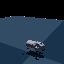

In [ ]:
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), num_envs))
media.show_image(state.obs['pixels/view_0'][0], width=128)

## Train a Simple Policy

In [ ]:
# @title Set up the model
from quadruped_mjx_rl.models import name_to_model

model_config = name_to_model["actor_critic"]()
model_config.modules.policy = [256, 256, 128]
model_config.modules.value = [256, 256, 128]

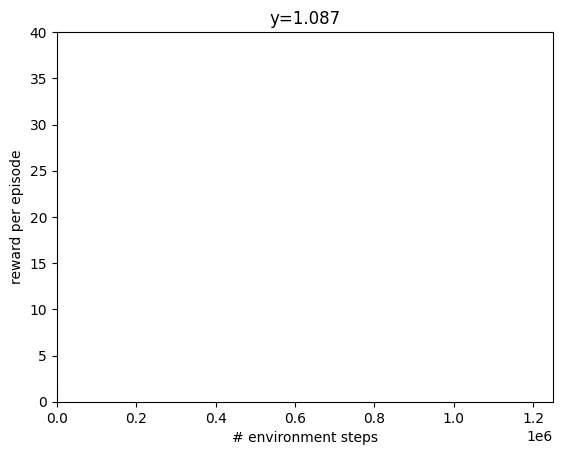

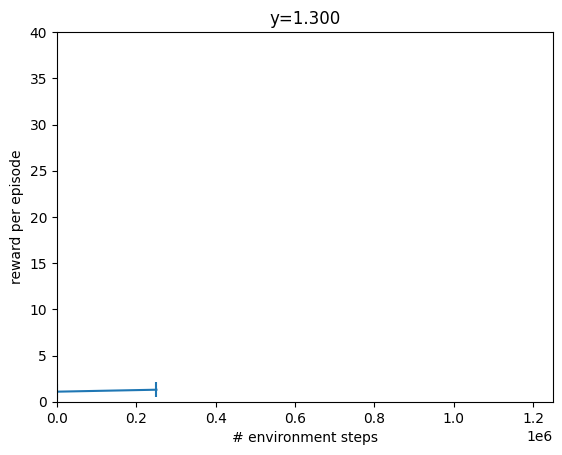

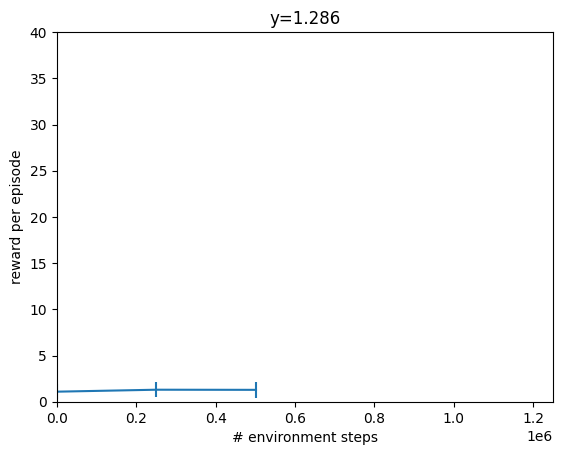

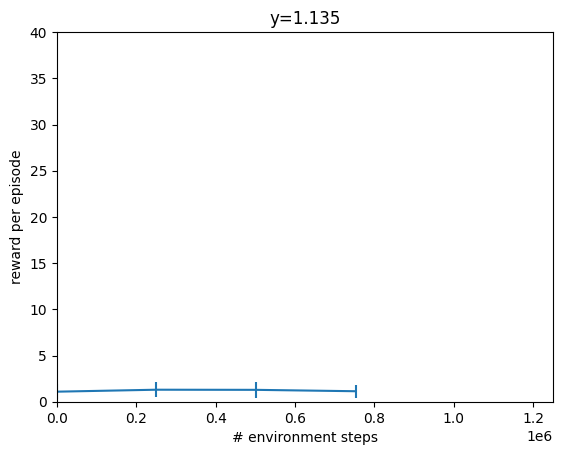

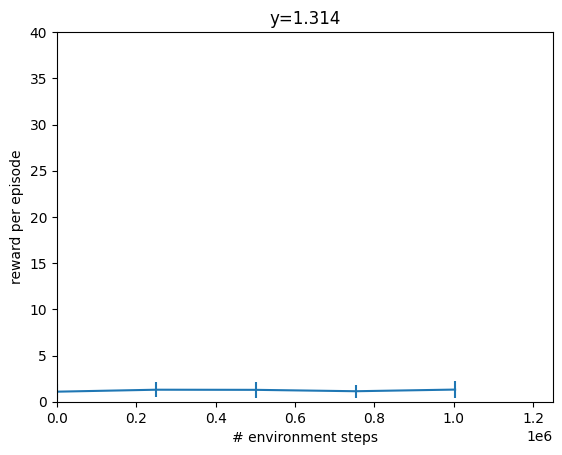

time to jit: 0:00:47.230316
time to train: 0:04:30.216965


In [ ]:
# @title Train
from quadruped_mjx_rl.training import train, TrainingConfigVisionPPO, ppo_train
from functools import partial

training_config = TrainingConfigVisionPPO()
training_config.episode_length = 100
training_config.num_envs = 128
training_config.num_eval_envs = 128
training_config.batch_size = 64

train(
    env=env,
    model_config=model_config,
    training_config=training_config,
    train_fn=partial(ppo_train.train, wrap_env=False),
    model_save_path="vision_simple_1",
    vision=True,
)

In [ ]:
# @title Render
from quadruped_mjx_rl.rendering import render_policy_rollout, RenderConfig

render_config = RenderConfig()

render_policy_rollout(
    env=env,
    model_config=model_config,
    trained_model_path="vision_simple_1",
    render_config=render_config,
    animation_save_path="vision_simple_1.gif",
    vision=True,
)

AttributeError: 'int' object has no attribute 'items'